# Elastic Deformations

Implementation and demonstration of elastic deformations (for data augmentation)

This approach to performing an elastic deformation on an image was described in the U-Net paper of Ronneberger et al. 2015. The deformation is applied as follows:<br/>
general idea: give every pixel a (slightly) new location, move every pixel a bit. The movement is described by displacement values dx(x,y) and dy(x,y) (dx displacement of pixel at (x,y) in x direction)

### 1) get displacement values on coarse grid
We want a very smooth deformation, so we pick only a few evenly spaced points in the image, generate a random displacement there. (e.g. on 3x3 grid)

### 2) interpolate displacement
Now we interpolate the dislplacement values between the coarse grid points -> get x and y displacement values for every pixel in input image

### 3) apply displacement
Finally, we interpolate the image at the new coordinates



In [1]:
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy import interpolate as ipol

def elastic_deform(image, stdev, grid_size):
    """ Applies random elastic deformation to the input image
    Input: image: array of shape (N.M,C) (Haven't tried it out for N != M), C number of channels
           stdev: nonnegative value 
           grid_size: int 
    Output: the deformed image (shape (N,M,C))
    """
    
    # TO DO: make it work on pairs of images 
    # IDEA: random grid points
    
    ## Preliminaries    
    # dimensions of the input image
    shape = image.shape
    
    ## Displacement values of coarse grid
    # sample a few displacement values in x and y direction (coarse)
    dx_coarse = np.random.randn(grid_size*grid_size)*stdev
    dy_coarse = np.random.randn(grid_size*grid_size)*stdev
    # set first line of dy to zero because we don't want to deform upper edge
    dy_coarse[0:grid_size] = 0
    # get coordinates for these displacement values (evenly spaced in x and y direction)
    coord_x_coarse = np.linspace(0, shape[0]-1, grid_size, dtype = int)
    coord_y_coarse = np.linspace(0, shape[1]-1, grid_size, dtype = int)
    coord_coarse = [[x,y] for x in coord_x_coarse for y in coord_y_coarse]
    
    ## Interpolation of the displacement values
    # coordinates of fine grid
    coord_fine = [[x,y] for x in range(shape[0]) for y in range(shape[0])]
    # interpolate displacements in both x and y direction
    dx_fine = ipol.griddata(coord_coarse, dx_coarse, coord_fine, method = 'cubic') # cubic works better but takes longer (?)
    dy_fine = ipol.griddata(coord_coarse, dy_coarse, coord_fine, method = 'cubic') # other options: 'linear'
    # get the displacements into shape of the input image (the same values in each channel)
    dx_fine = dx_fine.reshape(shape[0:2])
    dx_fine = np.stack([dx_fine]*shape[2], axis = -1)
    dy_fine = dy_fine.reshape(shape[0:2])
    dy_fine = np.stack([dy_fine]*shape[2], axis = -1)
    
    ## Deforming the image: apply the displacement grid
    # base grid 
    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]))
    # add displacement to base grid (-> new coordinates)
    indices = np.reshape(y+dy_fine, (-1, 1)), np.reshape(x+dx_fine, (-1, 1)), np.reshape(z, (-1, 1))
    # evaluate the image at the new coordinates
    deformed_image = map_coordinates(image, indices, order=2, mode='nearest')
    
    deformed_image = deformed_image.reshape(image.shape)
    
    return deformed_image

In [2]:
# import sample image
from PIL import Image
im = Image.open("chess.jpg")
im = np.asarray(im)

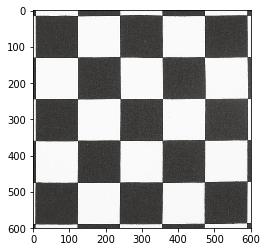

In [3]:
# showing image
%matplotlib inline

from matplotlib import pyplot as plt

plt.imshow(im)
plt.show()


In [4]:
transformed_im = elastic_deform(im, stdev = 20, grid_size = 3)

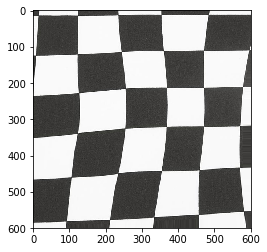

In [5]:
plt.imshow(transformed_im)
plt.show()

In [6]:
im_cat = Image.open("cat.jpg")
im_cat = np.asarray(im_cat)

In [7]:
transformed_im_cat = elastic_deform(im_cat, stdev = 10, grid_size = 3)

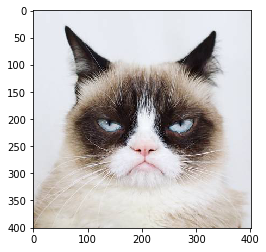

In [8]:
plt.imshow(im_cat)
plt.show()

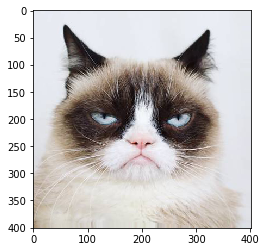

In [9]:
plt.imshow(transformed_im_cat)
plt.show()

## Second approach: deform at random points, keep edge of the image steady

This approach differs from the first one only in the construction of the coarse grid. It consists of two components: <br/>
1) random points where we want to generate the deformation<br/>
2) A frame for the image (8 points on the edges) where we want the deformation to be small/zero <br/>
These two sets of points and values get combined to form a coarse "grid" (not actually a grid, because of the random points inside of the frame) <br/> 

In [10]:
def elastic_deform_random_points(image, n_points, stdev_displacement, deformation_points_location_fac = 0.5):
    """ Applies random elastic deformation to the input image
    Input: image: array of shape (N.M,C) (Haven't tried it out for N != M), C number of channels
           n_points: int, number of random points for deformation
           stdev_displacement: nonnegative value, standard deviation for the displacement at the deformation points
           deformation_points_location_fac: value in (0,1), gives size of box in which the random points are generated
    Output: the deformed image (shape (N,M,C))
    """
        
    ## Preliminaries    
    # dimensions of the input image
    shape = image.shape
    # centers of x and y axis
    x_center = shape[1]/2
    y_center = shape[0]/2
    
    ## Construction of the coarse grid
    # deformation points: coordinates
    
    left_limit = int(x_center - deformation_points_location_fac*x_center)
    right_limit = int(x_center + deformation_points_location_fac*x_center)
    upper_limit = int(y_center - deformation_points_location_fac*y_center)
    lower_limit = int(y_center + deformation_points_location_fac*y_center)
    x_coord_deformation_points = np.random.randint(left_limit, right_limit, n_points) # from left_limit (inclusive) to right_limit (exclusive)
    y_coord_deformation_points = np.random.randint(upper_limit, lower_limit, n_points) 
    # deformation points: displacement values
    dx_deformation_points = np.random.randn(n_points)*stdev_displacement
    dy_deformation_points = np.random.randn(n_points)*stdev_displacement
    
    # anker points: coordinates    
    x_coord_anker_points = np.array([0, x_center, shape[1] - 1, 0, shape[1] - 1, 0, x_center, shape[1] - 1])
    y_coord_anker_points = np.array([0, 0, 0, y_center, y_center, shape[0] - 1, shape[0] - 1, shape[0] - 1])
    # anker points: values
    dx_anker_points = np.zeros(8)
    dy_anker_points = np.zeros(8)
    
    # combine deformation and anker points to coarse grid 
    x_coord_coarse = np.append(x_coord_deformation_points, x_coord_anker_points)
    y_coord_coarse = np.append(y_coord_deformation_points, y_coord_anker_points)
    coord_coarse = np.array(list(zip(x_coord_coarse, y_coord_coarse)))
    
    dx_coarse = np.append(dx_deformation_points, dx_anker_points)
    dy_coarse = np.append(dy_deformation_points, dy_anker_points)
        
    ## Interpolation onto fine grid
    # coordinates of fine grid
    coord_fine = [[x,y] for x in range(shape[1]) for y in range(shape[0])]
    # interpolate displacement in both x and y direction
    dx_fine = ipol.griddata(coord_coarse, dx_coarse, coord_fine, method = 'cubic') # cubic works better but takes longer (?)
    dy_fine = ipol.griddata(coord_coarse, dy_coarse, coord_fine, method = 'cubic') # other options: 'linear'
    # get the displacements into shape of the input image (the same values in each channel)
    dx_fine = dx_fine.reshape(shape[0:2])
    dx_fine = np.stack([dx_fine]*shape[2], axis = -1)
    dy_fine = dy_fine.reshape(shape[0:2])
    dy_fine = np.stack([dy_fine]*shape[2], axis = -1)
    
    ## Deforming the image: apply the displacement grid
    # base grid 
    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]))
    # add displacement to base grid (-> new coordinates)
    indices = np.reshape(y+dy_fine, (-1, 1)), np.reshape(x+dx_fine, (-1, 1)), np.reshape(z, (-1, 1))
    # evaluate the image at the new coordinates
    deformed_image = map_coordinates(image, indices, order=2, mode='nearest')
    deformed_image = deformed_image.reshape(image.shape)
    
    return deformed_image

In [18]:
transformed_im = elastic_deform_random_points(im, n_points = 3, 
                                              stdev_displacement = 10, deformation_points_location_fac = 0.5)

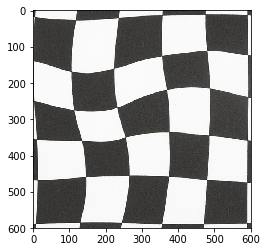

In [19]:
plt.imshow(transformed_im)
plt.show()

# Wrapper function and deform function

In [33]:
# deform function
def elastic_deformation(image, x_coord, y_coord, dx, dy):
    """ Applies random elastic deformation to the input image 
        with given coordinates and displacement values of deformation points.
        Keeps the edge of the image steady by adding a few frame points that get displacement value zero.
    Input: image: array of shape (N.M,C) (Haven't tried it out for N != M), C number of channels
           x_coord: array of shape (L,) contains the x coordinates for the deformation points
           y_coord: array of shape (L,) contains the y coordinates for the deformation points
           dx: array of shape (L,) contains the displacement values in x direction
           dy: array of shape (L,) contains the displacement values in x direction
    Output: the deformed image (shape (N,M,C))
    """
        
    ## Preliminaries    
    # dimensions of the input image
    shape = image.shape
        
    # centers of x and y axis
    x_center = shape[1]/2
    y_center = shape[0]/2
    
    ## Construction of the coarse grid
    # deformation points: coordinates
    
    #left_limit = int(x_center - deformation_points_location_fac*x_center)
    #right_limit = int(x_center + deformation_points_location_fac*x_center)
    #upper_limit = int(y_center - deformation_points_location_fac*y_center)
    #lower_limit = int(y_center + deformation_points_location_fac*y_center)
    #x_coord_deformation_points = np.random.randint(left_limit, right_limit, n_points) # from left_limit (inclusive) to right_limit (exclusive)
    #y_coord_deformation_points = np.random.randint(upper_limit, lower_limit, n_points) 
    # deformation points: displacement values
    #dx_deformation_points = np.random.randn(n_points)*stdev_displacement
    #dy_deformation_points = np.random.randn(n_points)*stdev_displacement
        
    # anker points: coordinates    
    x_coord_anker_points = np.array([0, x_center, shape[1] - 1, 0, shape[1] - 1, 0, x_center, shape[1] - 1])
    y_coord_anker_points = np.array([0, 0, 0, y_center, y_center, shape[0] - 1, shape[0] - 1, shape[0] - 1])
    # anker points: values
    dx_anker_points = np.zeros(8)
    dy_anker_points = np.zeros(8)
    
    # combine deformation and anker points to coarse grid 
    x_coord_coarse = np.append(x_coord, x_coord_anker_points)
    y_coord_coarse = np.append(y_coord, y_coord_anker_points)
    coord_coarse = np.array(list(zip(x_coord_coarse, y_coord_coarse)))
    
    dx_coarse = np.append(dx, dx_anker_points)
    dy_coarse = np.append(dy, dy_anker_points)
        
    ## Interpolation onto fine grid
    # coordinates of fine grid
    coord_fine = [[x,y] for x in range(shape[1]) for y in range(shape[0])]
    # interpolate displacement in both x and y direction
    dx_fine = ipol.griddata(coord_coarse, dx_coarse, coord_fine, method = 'cubic') # cubic works better but takes longer (?)
    dy_fine = ipol.griddata(coord_coarse, dy_coarse, coord_fine, method = 'cubic') # other options: 'linear'
    # get the displacements into shape of the input image (the same values in each channel)
    dx_fine = dx_fine.reshape(shape[0:2])
    dx_fine = np.stack([dx_fine]*shape[2], axis = -1)
    dy_fine = dy_fine.reshape(shape[0:2])
    dy_fine = np.stack([dy_fine]*shape[2], axis = -1)
    
    ## Deforming the image: apply the displacement grid
    # base grid 
    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]))
    # add displacement to base grid (-> new coordinates)
    indices = np.reshape(y+dy_fine, (-1, 1)), np.reshape(x+dx_fine, (-1, 1)), np.reshape(z, (-1, 1))
    # evaluate the image at the new coordinates
    deformed_image = map_coordinates(image, indices, order=2, mode='nearest')
    deformed_image = deformed_image.reshape(image.shape)
    
    return deformed_image







In [34]:
# wrapper function
def elastic_deform_wrapper(image1, image2, n_points, stdev_displacement, deformation_points_location_fac = 0.5):
    """ Generates random points and displacements and performs elastic deformation 
        on the two input images with these deformation points
        Input: image1, image2: arrays of shape (N,M,C), C being the number of channels
               n_points: number of deformation points
               stdev_displacement: standard deviation of the discplacement values
               deformation_points_location_fac: value in (0,1), gives size of box in which the random points are generated
        Output: the deformed images (shape (N,M,C))
               """
    ## Preliminaries 
    # dimensions of the input images
    shape = image1.shape
    
    # centers of x and y axis
    x_center = shape[1]/2
    y_center = shape[0]/2
    
    ## deformation points
    # coordinates
    left_limit = int(x_center - deformation_points_location_fac*x_center)
    right_limit = int(x_center + deformation_points_location_fac*x_center)
    upper_limit = int(y_center - deformation_points_location_fac*y_center)
    lower_limit = int(y_center + deformation_points_location_fac*y_center)
    x_coord = np.random.randint(left_limit, right_limit, n_points) # from left_limit (inclusive) to right_limit (exclusive)
    y_coord = np.random.randint(upper_limit, lower_limit, n_points) 
    
    # displacement values
    dx = np.random.randn(n_points)*stdev_displacement
    dy = np.random.randn(n_points)*stdev_displacement
    
    ## perform the elastic deformation
    deformed_image1 = elastic_deformation(image1, x_coord, y_coord, dx, dy)
    deformed_image2 = elastic_deformation(image2, x_coord, y_coord, dx, dy)
    
    return deformed_image1, deformed_image2


In [38]:
image1, image2 = elastic_deform_wrapper(im, im, n_points= 1, stdev_displacement = 10)

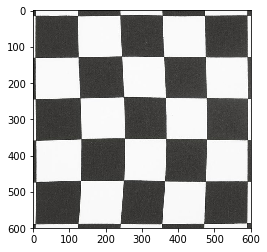

In [39]:
plt.imshow(image1)
plt.show()

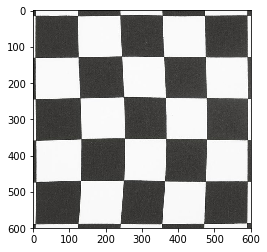

In [40]:
plt.imshow(image2)
plt.show()